In [1]:
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.insert(0, '../zdrojaky/kf')
from kf import KF
from trajectory import trajectory
np.set_printoptions(precision=2)

# Cvičení 3: Sledování objektu ve 2D

Cílem tohoto cvičení je filtrace polohy objektu pohybujícího se na ploše, tj. ve 2D. Cílem je odhadovat stavový vektor sestávající se z polohy v osách $x_1$ a $x_2$ a rychlostech v obou těchto osách.

$$
x_t =
\begin{bmatrix}
x_{1,t} \\ 
x_{2,t} \\ 
v_{x_1,t} \\ 
v_{x_2,t}
\end{bmatrix}
$$

Víme, že pro polohu v první ose platí

$$
x_{1,t} = x_{1,t-1} + v_{x_1,t} dt + w_{x_1,t},
$$

a že analogicky platí totéž i pro polohu v ose druhé. Abychom se nemuseli zaobírat zrychlením, budeme uvažovat, že rychlost je stejná a její změny jsou způsobeny jen šumem,

$$
v_{x_1,t} = v_{x_1, t-1} + w_{vx_1, t}.
$$

Analogicky pro druhou složku rychlosti. K dispozici jsou jen měření polohy v obou osách a to v časovém kroku 0.1s.

Potřebujeme tedy sestavit stavový model

$$
\begin{aligned}
x_t &\sim \mathcal{N}(Ax_{t-1} + Bu_t, Q),\\
y_t &\sim \mathcal{N}(Hx_{t}, R).
\end{aligned}
$$

**Úkol 1: Sestavte stavový model a určete matice**

Kovarianční matice nám musí někdo dodat, níže jsou uvedeny.

\begin{align*}
    A &=
    \begin{bmatrix}
       1 & 0 & dt & 0 \\
       0 & 1 & 0 & dt \\
       0 & 0 & 1 &  0 \\
       0 & 0 & 0 &  1 
    \end{bmatrix},
    \quad
    &Q &= q\cdot
    \begin{bmatrix}
        \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2}  & 0  \\
        0                 & \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2} \\
        \frac{dt^{2}}{2}  & 0                 & dt                & 0 \\
        0                 & \frac{dt^{2}}{2}  & 0                 & dt
    \end{bmatrix}
    \notag \\
    H &=
    \begin{bmatrix}
        1 & 0 &0 & 0 \\
        0 & 1 &0 & 0
    \end{bmatrix}
    \quad
    &R &=
    r^{2}\cdot
    \begin{bmatrix}
        1 & 0 \\
        0 & 1
    \end{bmatrix}
\end{align*}
kde $dt = 0.1$, $q = 2$, $r=0.5$.

**Úkol 2: dodefinujte proměnné**

In [2]:
q = 2
dt = 0.1
r = 0.5

Q = [[dt*dt*dt/3, 0, dt*dt/2, 0],
     [0, dt*dt*dt/3, 0, dt*dt/2],
     [dt*dt/2, 0, dt, 0],
     [0, dt*dt/2, 0, dt]]

A = np.identity(4)
A[0,2] = dt
A[1,3] = dt

H = np.zeros(shape=(2,4))
H[0,0] = 1
H[1,1] = 1

Q = q * np.array(Q)
R = r*r*np.identity(2)

print('A:\n', A)
print('H:\n', H)

A:
 [[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
H:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]]


**Úkol 3: doplňte za `code` den a měsíc svého svátku. V objektu `traj` budete mít trajektorii o 100 řádcích, v každém je poloha v obou osách. Vykreslete ji křížky.**

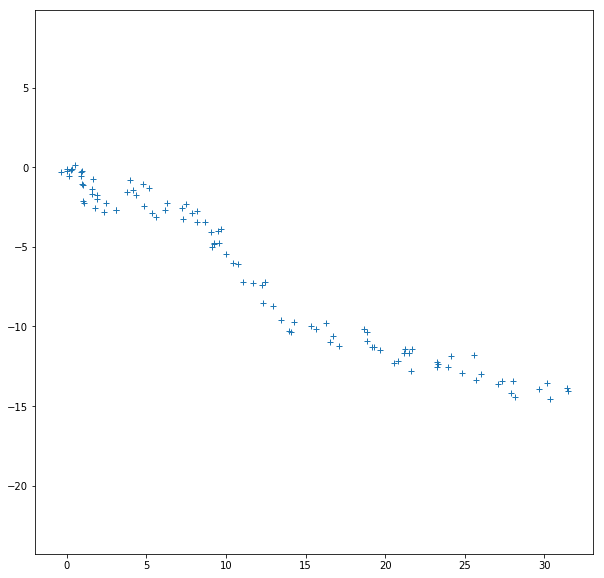

(2, 100)

In [11]:
code = 213
traj = trajectory(code)
plt.figure(figsize=(10, 10))
plt.plot(traj.Y[0], traj.Y[1], '+')
plt.axis('equal')
plt.show()
traj.Y.shape

Kalmanův filtr je napsán jako třída KF. Tu si jednoduše pustíme, provede výpočty za vás. Předávají se jí jednotlivá měření polohy, tj. řádky v `traj.Y.T`

In [12]:
kf = KF(A=A, B=None, H=H, R=R, Q=Q)
for yt in traj.Y.T:
    kf.predict()
    kf.update(yt)
    kf.log()

log_x = np.array(kf.log_x).T      # Zde najdeme odhad

**Úkol 4: `log_x` má 4 řádky, v každém sloupci je jeden odhad stavu $x_{t}$. Vykreslete stejně jako výše naměřenou polohu a její filtrovaný odhad.**

In [14]:
log_x.shape

(4, 100)

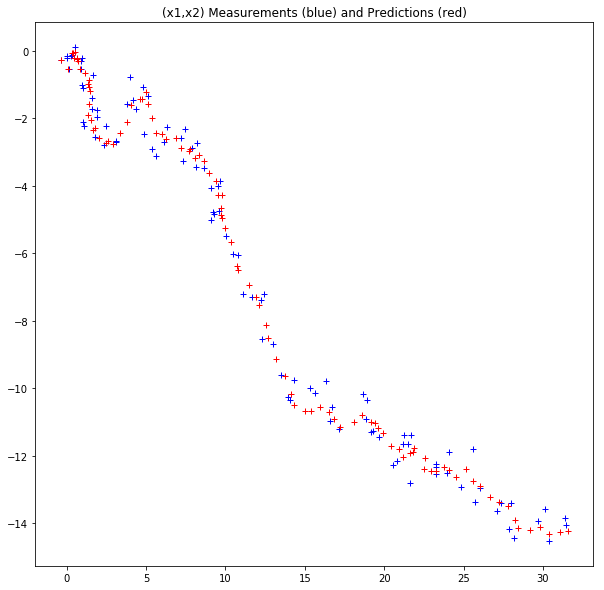

In [27]:
plt.figure(figsize=(10,10))
plt.plot(traj.Y[0], traj.Y[1], 'b+')
plt.plot(log_x[0], log_x[1], 'r+')
plt.xlabel = 'x1'
plt.ylabel = 'x2'
plt.title('(x1,x2) Measurements (blue) and Predictions (red)')
plt.show()

**Úkol 5: V odhadech najdete i odhady rychlosti. Vykreslete je jako 2 subploty vedle sebe.**

<Figure size 1080x504 with 0 Axes>

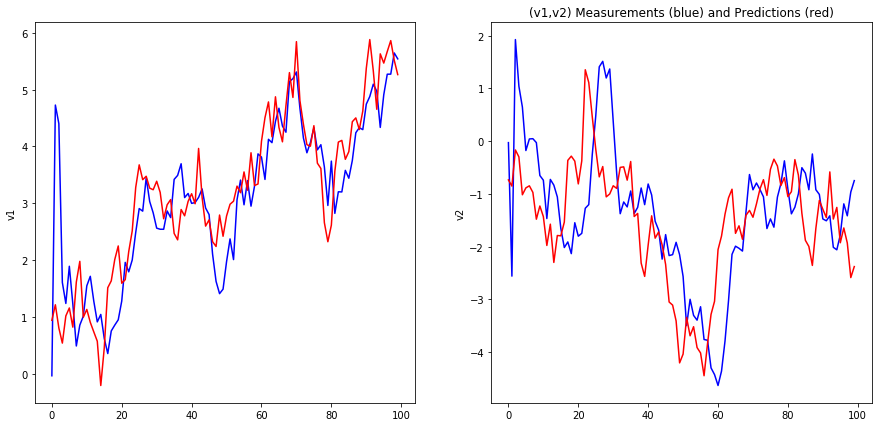

In [32]:
plt.figure(figsize=(15, 7))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 7))
ax1.plot(range(log_x.shape[1]), log_x[2], 'b')
ax1.plot(range(log_x.shape[1]), traj.X[2], 'r')
ax1.set_ylabel('v1')
ax2.plot(range(log_x.shape[1]), log_x[3], 'b')
ax2.plot(range(log_x.shape[1]), traj.X[3], 'r')
ax2.set_ylabel('v2')
plt.title('(v1,v2) Measurements (blue) and Predictions (red)')
plt.show()

**Úkol 6: `traj` má atribut X, tedy `traj.X`, což je matice o 4 řádcích, obsahující skutečné hodnoty polohy a rychlosti, které jsme se snažili Kalmanovým filtrem odhadnout. Doplňte je do obrázků černě.**